##  Import thư viện

In [138]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



## Đọc dữ liệu

In [139]:
# Đọc dữ liệu từ train.csv, val.csv, test.csv
train_data = pd.read_csv(r"..\Data\Train_and_Test_dataset\train.csv")
val_data = pd.read_csv(r"..\Data\Train_and_Test_dataset\val.csv")
test_data = pd.read_csv(r"..\Data\Train_and_Test_dataset\test.csv")

# Xem qua dữ liệu
print(train_data)


                        title  \
0          Tipping the Velvet   
1                The Thin Man   
2               Saving Steele   
3          The Winthrop Woman   
4           Operation Redwood   
...                       ...   
21922  The Philadelphia Story   
21923               Surfacing   
21924          A Clan in Need   
21925                 Beastly   
21926               Slow Down   

                                                  author  \
0                                           Sarah Waters   
1                                       Dashiell Hammett   
2                          Anne Jolin (Goodreads Author)   
3      Anya Seton, Philippa Gregory (Goodreads Author...   
4                                      S. Terrell French   
...                                                  ...   
21922                                       Philip Barry   
21923                 Margaret Atwood (Goodreads Author)   
21924  Erin Hunter, Dan Jolley (Goodreads Author), Ja...   
219

In [141]:
def group_description(df):
    df['description'] = df['title'] + " " + df['author'] + " " + df['description']
    return df

In [142]:
train_data = group_description(train_data)
test_data = group_description(test_data)
val_data = group_description(val_data)

## Tiền xử lý nhãn (multi-label)

In [144]:
# Chuyển nhãn từ chuỗi sang danh sách
train_data["genres"] = train_data["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
test_data["genres"] = test_data["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
val_data["genres"] = val_data["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])

# Binarize nhãn
mlb = MultiLabelBinarizer()
train_labels_binary = mlb.fit_transform(train_data["genres"])
test_labels_binary = mlb.transform(test_data["genres"])
val_labels_binary = mlb.transform(val_data["genres"])

print(f"Số lượng nhãn: {len(mlb.classes_)}")

Số lượng nhãn: 5


## Tiền xử lý văn bản

In [146]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tạo tokenizer
tokenizer = Tokenizer(num_words=50000)  # Tối đa 50,000 từ
tokenizer.fit_on_texts(train_data['description'])

# Biến đổi văn bản thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(train_data['description'])
X_val_seq = tokenizer.texts_to_sequences(val_data['description'])
X_test_seq = tokenizer.texts_to_sequences(test_data['description'])

# Đệm chuỗi để có độ dài cố định
MAX_SEQ_LEN = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding='post')


## Xây dựng mô hình CNN

In [ ]:
# Siêu tham số
VOCAB_SIZE = 50000  # Kích thước từ vựng
EMBEDDING_DIM = 128  # Kích thước vector nhúng
NUM_CLASSES = 5  # Số lượng nhãn
MAX_SEQ_LEN = 500  # Độ dài tối đa của văn bản

# 1. Input layer
input_text = Input(shape=(MAX_SEQ_LEN,), name="Input")

# 2. Embedding layer
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN)(input_text)

# 3. Convolutional layers với Batch Normalization và L2 Regularization
conv_3 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(embedding)
conv_3 = BatchNormalization()(conv_3)
pool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(filters=128, kernel_size=4, activation='relu', padding='same', kernel_regularizer=l2(0.01))(embedding)
conv_4 = BatchNormalization()(conv_4)
pool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.01))(embedding)
conv_5 = BatchNormalization()(conv_5)
pool_5 = GlobalMaxPooling1D()(conv_5)

# 4. Combine features
concat = tf.keras.layers.concatenate([pool_3, pool_4, pool_5])

# 5. Dense layers với Dropout
dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.6)(dense)  # Giảm overfitting với Dropout
output = Dense(NUM_CLASSES, activation='sigmoid', name="Output")(dense)

# 6. Build model
model = Model(inputs=input_text, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-3),  
    loss='binary_crossentropy',  
    metrics=['accuracy']
)

model.summary()





c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 500)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 500, 128)  │  6,400,000 │ Input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 500, 128)  │     49,280 │ embedding_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 500, 128)  │     65,664 │ embedding_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 500, 128)  │     82,048 │ embedding_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 128)  │        512 │ conv1d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 128)  │        512 │ conv1d_46[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 128)  │        512 │ conv1d_47[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     49,280 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 5)         │        645 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,648,453 (25.36 MB)

 Trainable params: 6,647,685 (25.36 MB)

 Non-trainable params: 768 (3.00 KB)

## Huấn luyện mô hình

In [149]:
history = model.fit(
    X_train_pad, train_labels_binary,
    validation_data=(X_val_pad, val_labels_binary),
    epochs=5,  
    batch_size=32
)

Epoch 1/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - accuracy: 0.3044 - loss: 1.6729 - val_accuracy: 0.2988 - val_loss: 0.5792
Epoch 2/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.3256 - loss: 0.5588 - val_accuracy: 0.3868 - val_loss: 0.5116
Epoch 3/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.4389 - loss: 0.4631 - val_accuracy: 0.4267 - val_loss: 0.4712
Epoch 4/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.4628 - loss: 0.4023 - val_accuracy: 0.4854 - val_loss: 0.4766
Epoch 5/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.4873 - loss: 0.3550 - val_accuracy: 0.4858 - val_loss: 0.4988


## Đánh giá mô hình

In [ ]:
# Đánh giá trên tệp val
loss, accuracy = model.evaluate(X_val_pad, val_labels_binary)
print(f"Valid Loss: {loss}, Valid Accuracy: {accuracy}")

229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4808 - loss: 0.4943
Valid Loss: 0.4988054931163788, Valid Accuracy: 0.4858393669128418


In [ ]:
# Đánh giá trên tệp test
loss, accuracy = model.evaluate(X_test_pad, test_labels_binary)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4725 - loss: 0.4900
Test Loss: 0.48802947998046875, Test Accuracy: 0.4837871193885803


In [158]:

# Dự đoán trên tập valid
y_pred = model.predict(X_val_pad)

# Chuyển đổi xác suất thành nhãn (0 hoặc 1) với ngưỡng 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Tính F1-Score, Precision, Recall
f1 = f1_score(val_labels_binary, y_pred_binary, average='micro')  
precision = precision_score(val_labels_binary, y_pred_binary, average='micro')
recall = recall_score(val_labels_binary, y_pred_binary, average='micro')

# In kết quả
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
F1-Score: 0.8167
Precision: 0.8237
Recall: 0.8098


In [156]:

# Dự đoán trên tập test
y_pred = model.predict(X_test_pad)

# Chuyển đổi xác suất thành nhãn (0 hoặc 1) với ngưỡng 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Tính F1-Score, Precision, Recall
f1 = f1_score(test_labels_binary, y_pred_binary, average='micro')  
precision = precision_score(test_labels_binary, y_pred_binary, average='micro')
recall = recall_score(test_labels_binary, y_pred_binary, average='micro')

# In kết quả
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
F1-Score: 0.8194
Precision: 0.8298
Recall: 0.8092


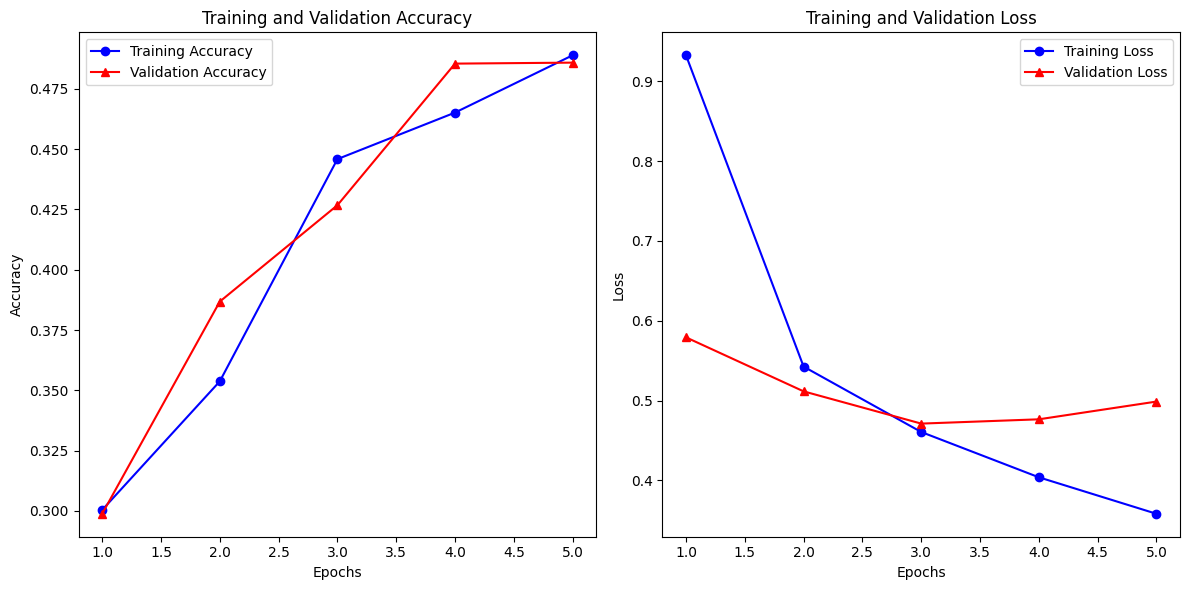

In [152]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ lịch sử huấn luyện
def plot_training_history(history):
    # Lấy thông tin từ lịch sử huấn luyện
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Số lượng epochs
    epochs = range(1, len(acc) + 1)
    
    # Vẽ biểu đồ Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Vẽ biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Gọi hàm sau khi huấn luyện mô hình
plot_training_history(history)
